In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/data/nihaifeng/code/HeliosArtifact/simulator')
import utils

In [10]:
import psutil
import os

def kill_python_processes():
    current_user = os.getlogin()  # 获取当前用户
    target_pid_threshold = 409862
    target_name = "python"
    
    # 遍历所有进程
    for proc in psutil.process_iter(attrs=["pid", "name", "username"]):
        try:
            pid = proc.info["pid"]
            name = proc.info["name"]
            username = proc.info["username"]
            
            # 筛选满足条件的进程
            if username == current_user and name == target_name and pid > target_pid_threshold:
                print(f"Killing process: PID={pid}, Name={name}, User={username}")
                proc.terminate()  # 尝试优雅终止进程
                proc.wait(timeout=3)  # 等待进程结束
        except (psutil.NoSuchProcess, psutil.AccessDenied, psutil.ZombieProcess):
            pass  # 忽略异常


kill_python_processes()


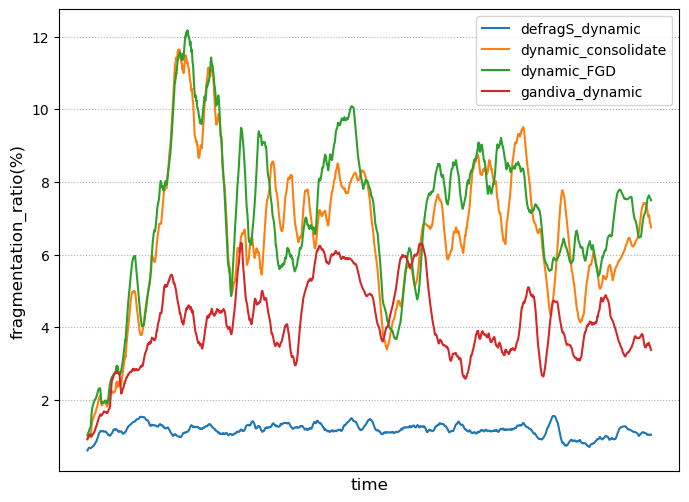

In [12]:
# schedulers = ["defragS_fifo", "fifo_consolidate", "gandiva_fifo", "fifo_FGD",]
# schedulers = ["defragS_fifo_ckpt", "fifo_consolidate", "gandiva_fifo_ckpt", "fifo_FGD",]
# schedulers = ["defragS_dynamic_ckpt", "dynamic_consolidate", "dynamic_FGD", "gandiva_dynamic_ckpt"]
schedulers = ["defragS_dynamic", "dynamic_consolidate", "dynamic_FGD", "gandiva_dynamic"]
log_dir = "../log/tmp/Philly_mutation_05" 

saving = False
window_size = 60 * 24 * 1

utilization = 'fragmentation_ratio' #
fig = plt.figure(figsize=(8,6))
for idx, scheduler in enumerate(schedulers):
	df = pd.read_csv(log_dir+f'/Philly_{scheduler}/all/{scheduler}_all_seq.csv')
	y = df[utilization]*100
	plt.plot(df['time'], y.rolling(window=window_size).mean(), label=scheduler)

plt.xlabel('time', fontsize=12)
plt.xticks([])
plt.ylabel(f'{utilization}(%)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(linestyle=':')
plt.show()

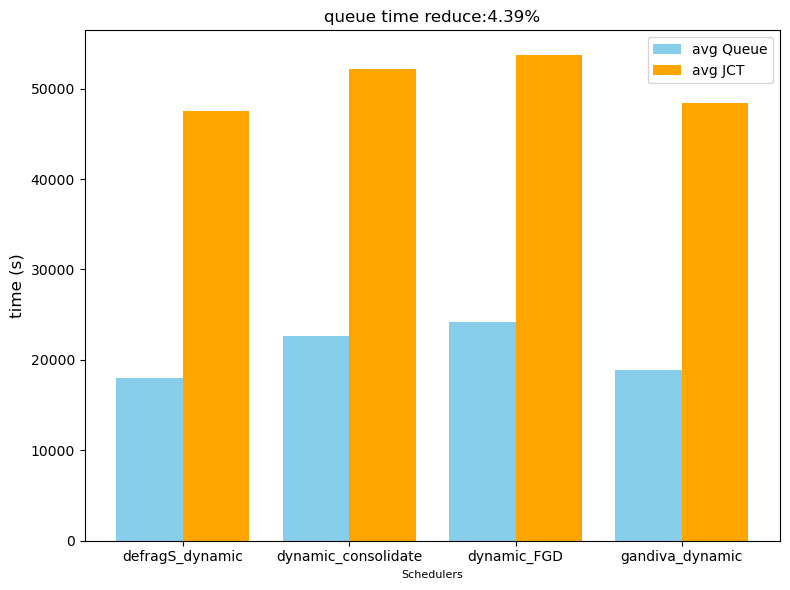

que_list:  [18032, 22680, 24226, 18860]
jct_list:  [47570, 52219, 53765, 48399]


In [13]:
que_list, jct_list = [], []
for scheduler in schedulers:
	df = pd.read_csv(log_dir+f'/Philly_{scheduler}/jct_avg.csv')
	jct_list.append(df.iloc[len(df)-1, 1])
	df = pd.read_csv(log_dir+f'/Philly_{scheduler}/que_avg.csv')
	que_list.append(df.iloc[len(df)-1, 1])
		

# 设置柱状图的宽度和位置
x_indices = np.arange(len(schedulers))  # x 轴位置
bar_width = 0.4  # 每个柱的宽度

fig = plt.figure(figsize=(8, 6))
# 绘制两组柱状图
plt.bar(x_indices - bar_width/2, que_list, bar_width, label='avg Queue', color='skyblue')
plt.bar(x_indices + bar_width/2, jct_list, bar_width, label='avg JCT', color='orange')

# 设置 x 轴标签
plt.xticks(x_indices, schedulers)
# plt.yticks([])

# 添加标题和坐标轴标签
plt.xlabel("Schedulers", fontsize=8)
plt.ylabel("time (s)", fontsize=12)

# 添加图例
plt.legend()

# 显示图表
dfs = que_list[0]
tmp = que_list[1:]
plt.title( f'queue time reduce:{(min(tmp)-dfs)/min(tmp)*100:.2f}%', fontsize=12)
plt.tight_layout()
plt.show()
print("que_list: ", que_list)
print("jct_list: ", jct_list)

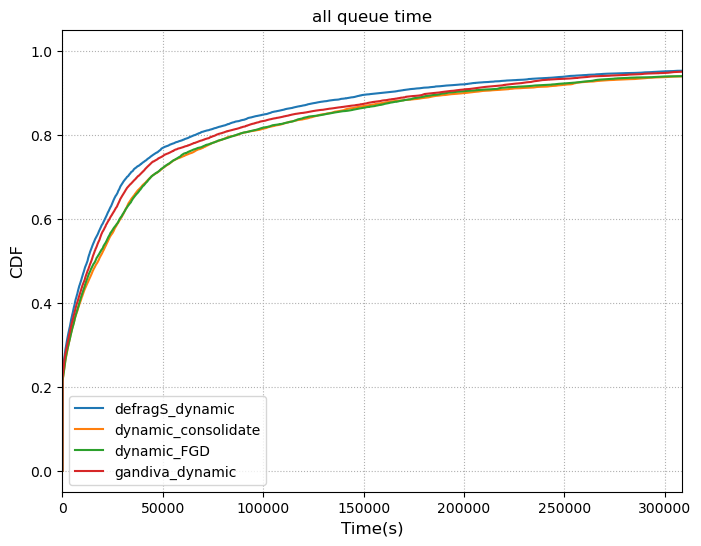

In [9]:
data_type = "queue"
cluster = 'all'  # ['7f04ca', 'ed69ec', '6214e9', '0e4a51', 'b436b2', '103959', '11cb48', '2869ce', 'ee9e8c', 'e13805', '6c71a0'] 'all'

fig = plt.figure(figsize=(8,6))
for idx, scheduler in enumerate(schedulers):
	df = pd.read_csv(log_dir+f'/Philly_{scheduler}/{cluster}/{scheduler}_{cluster}_log.csv')
	df = df[df['gpu_num'] >= 8]
	y = df[data_type]
	sorted_y = np.sort(y)
	cdf = np.arange(1, len(sorted_y) + 1) / len(sorted_y)
	plt.plot(sorted_y, cdf, label=scheduler)

x_min = np.min(sorted_y)
x_max = np.percentile(sorted_y, 95)  # 选择中位数作为最大范围
plt.xlim(x_min, x_max)  # 设置 x 轴范围

plt.title(f"{cluster} {data_type} time")
plt.xlabel('Time(s)', fontsize=12)
plt.ylabel('CDF', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(linestyle=':')
plt.show()

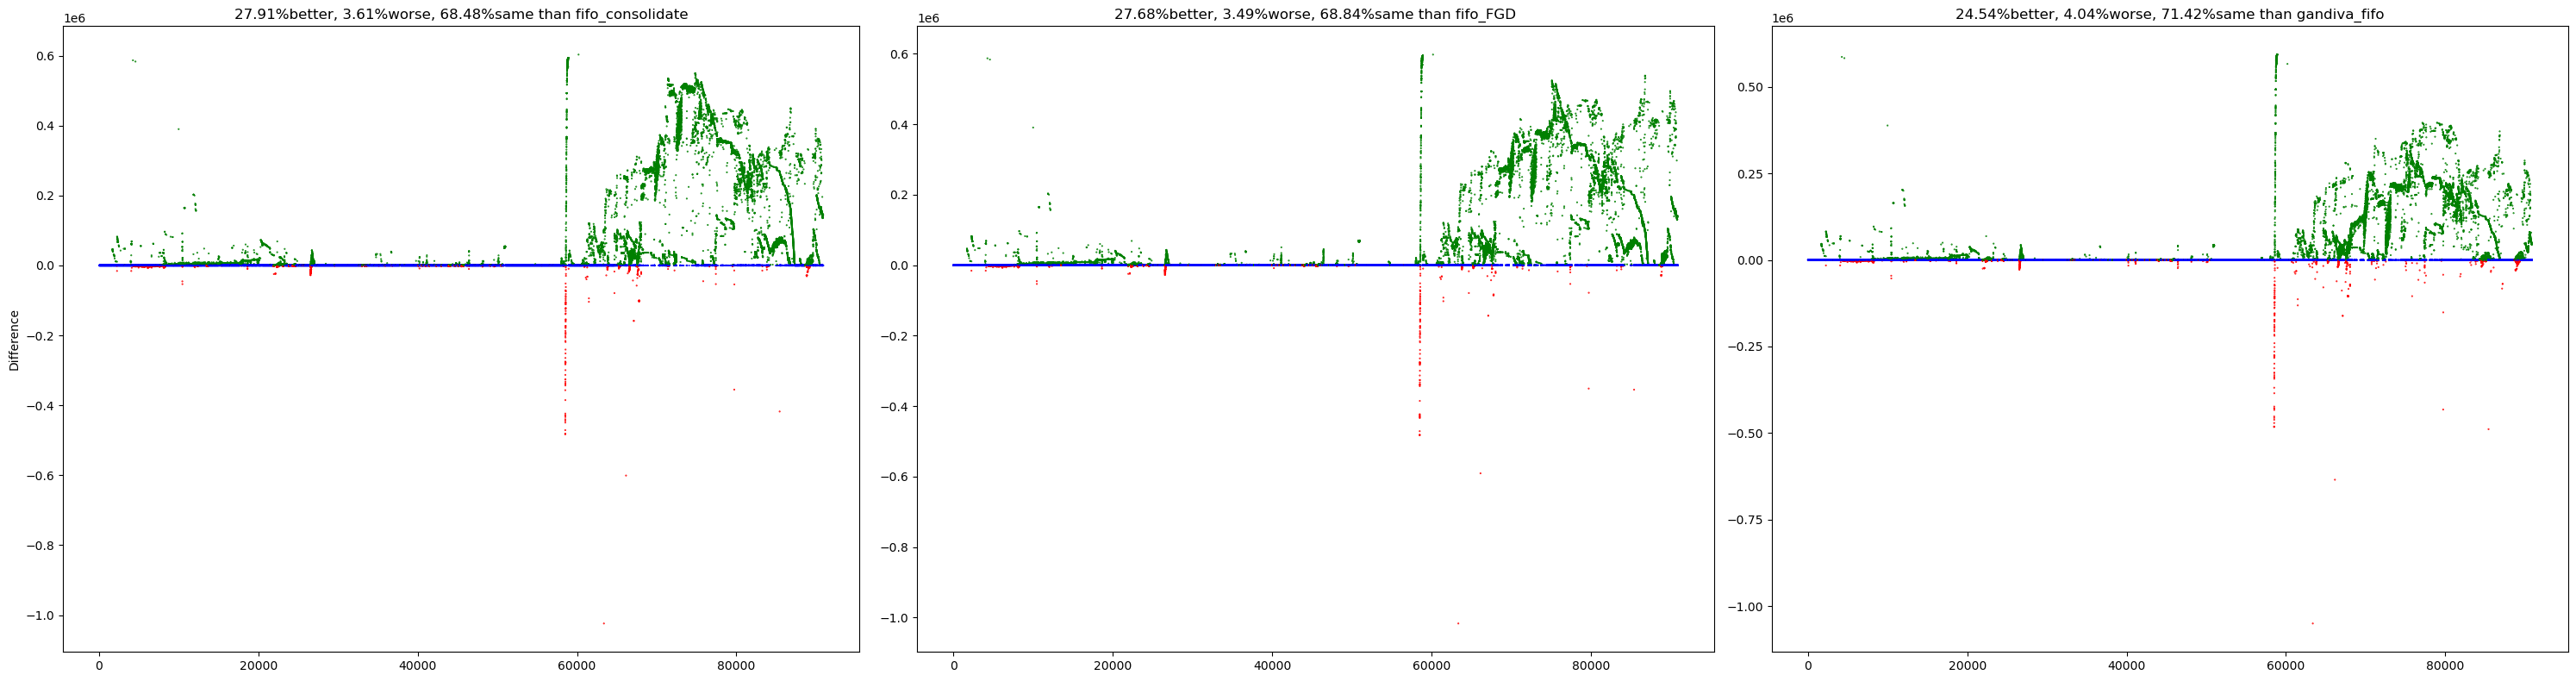

In [12]:
# 画(baseline.queue - DefragS.queue)的散点图
final_df = pd.DataFrame()
GPU_NUM = -1

fig, axes = plt.subplots(1, 3, figsize=(30, 8))
axes = axes.flatten()
dynamic_df = pd.read_csv(log_dir+f'/Philly_{schedulers[0]}/all/{schedulers[0]}_all_log.csv')
dynamic_df.set_index('jobname', inplace=True)
if GPU_NUM > 0:
	dynamic_df = dynamic_df[dynamic_df['gpu_num'] == GPU_NUM]

for i in range(1, len(schedulers)):
	ax = axes[i-1]
	scheduler = schedulers[i]
	df = pd.read_csv(log_dir+f'/Philly_{scheduler}/all/{scheduler}_all_log.csv')
	df.set_index('jobname', inplace=True)
	if GPU_NUM > 0:
		df = df[df['gpu_num'] == GPU_NUM]

	difference = (df['queue'] - dynamic_df['queue'])  # / df['duration']
	colors = ['green' if diff > 0 else 'red' if diff < 0 else 'blue' for diff in difference]

	ax.scatter(range(len(difference)), difference, marker='.', s=1, c=colors)
	ax.set_title(f"{len([x for x in difference if x > 0])/len(df)*100:.2f}%better, {len([x for x in difference if x < 0])/len(df)*100:.2f}%worse, {len([x for x in difference if x == 0])/len(df)*100:.2f}%same than {scheduler}")
	if i == 1:
		ax.set_ylabel("Difference")

	bad_jobs = difference[difference < 0].index
	good_jobs = difference[difference > 0].index
	bad_df = df.loc[bad_jobs]
	good_df = df.loc[good_jobs]
	tmp_df = pd.DataFrame(data={
        f"{scheduler}_bad": bad_df['gpu_num'].value_counts(),
        f"{scheduler}_good": good_df['gpu_num'].value_counts()
    })
	final_df = pd.concat([final_df, tmp_df], axis=1)

plt.tight_layout()
plt.show()

# final_df.replace(np.nan, 0, inplace=True)
# output_path = log_dir + "/gpu_num_analysis.csv"
# final_df.to_csv(output_path)

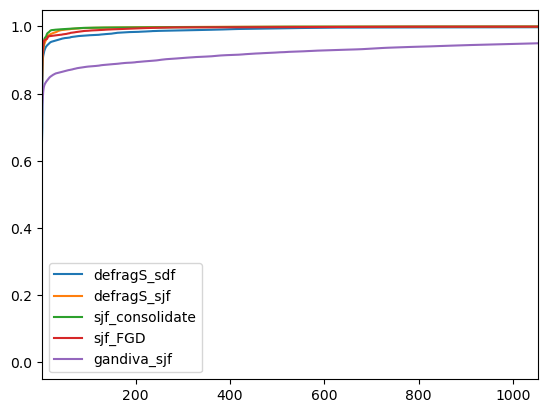

{'defragS_sdf': 20.01, 'defragS_sjf': 3.81, 'sjf_consolidate': 3.48, 'sjf_FGD': 6.18, 'gandiva_sjf': 334.86}


In [13]:
slowdowns = {}
# schedulers = ['defragS_dynamic_new', 'defragS_fifo', 'fifo_consolidate', 'fifo_FGD', 'gandiva_fifo']
# log_dir = '../log/test/Philly'
for scheduler in schedulers:
	df = pd.read_csv(log_dir+f'/Philly_{scheduler}/all/{scheduler}_all_log.csv')
	df['slowdown'] = (df['queue'] + df['duration']) / df['duration']
	# df = df[df['slowdown'] > 1]
	# plt.scatter(range(len(df)), df.slowdown, s = 1)
	# plt.title('slowdown')
	# plt.show()
	# plt.scatter(range(len(df)),df.duration, s= 1)
	# plt.title('duration')
	# plt.show()
	# plt.scatter(range(len(df)), df.gpu_num, s=1)
	# plt.title('gpu_num')
	# plt.show()
	# print(df.to_csv('test.csv'))
	# break
	slowdowns[scheduler] = round(df['slowdown'].mean(), 2)
	y = df['slowdown']
	sorted_y = np.sort(y)
	cdf = np.arange(1, len(sorted_y) + 1) / len(sorted_y)
	plt.plot(sorted_y, cdf, label=scheduler)
x_min = np.min(sorted_y)
x_max = np.percentile(sorted_y, 95)  # 选择中位数作为最大范围
plt.xlim(x_min, x_max)  # 设置 x 轴范围
plt.legend()
plt.show()
print(slowdowns)

相同调度算法时，SJF的Queue Time就是比FIFO好很多，无论大作业还是小作业。虽然可能存在不公平现在，但不公平之后的Queue Time也比公平的FIFO好很多

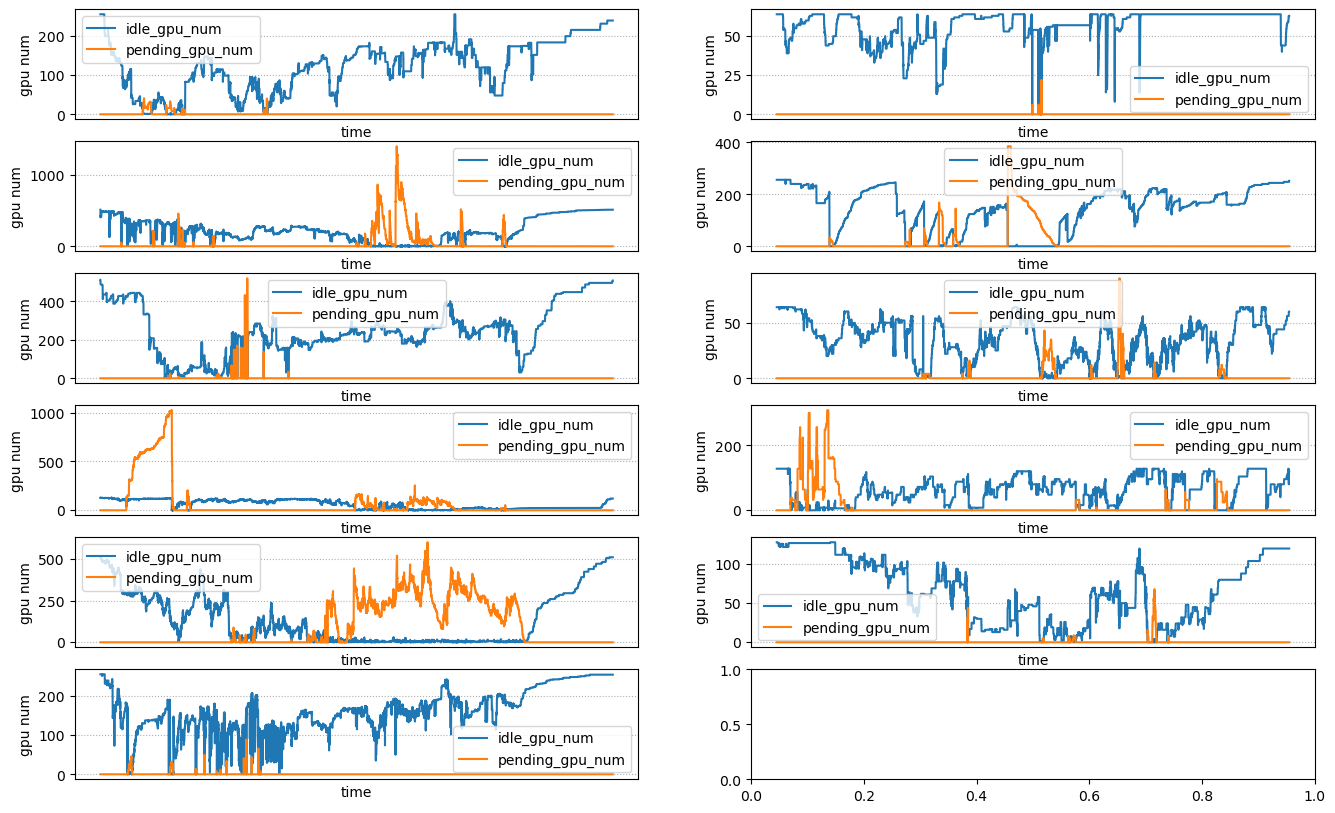

In [4]:
# 画每个VC的pending_gpu_num, idle_gpu_num 曲线

vc_ls = os.listdir(log_dir + f'/Philly_{schedulers[0]}')
vc_ls.remove('all')
vc_ls.remove('logfile')
vc_ls.remove('jct_avg.csv')
vc_ls.remove('que_avg.csv')

scheduler = schedulers[0]

fig, axes = plt.subplots(6, 2, figsize=(16,10))
axes = axes.flatten() 
for idx, vc in enumerate(vc_ls):
	ax = axes[idx]
	df = pd.read_csv(log_dir + f'/Philly_{scheduler}/{vc}/{scheduler}_{vc}_seq.csv')
	ax.plot(df['idle_gpu_num'], label='idle_gpu_num')
	ax.plot(df['pending_gpu_num'], label='pending_gpu_num')
	ax.set_ylabel('gpu num')
	ax.legend(loc='best')
	ax.set_xlabel('time')
	ax.set_xticks([])
	ax.grid(linestyle=':')
plt.show()


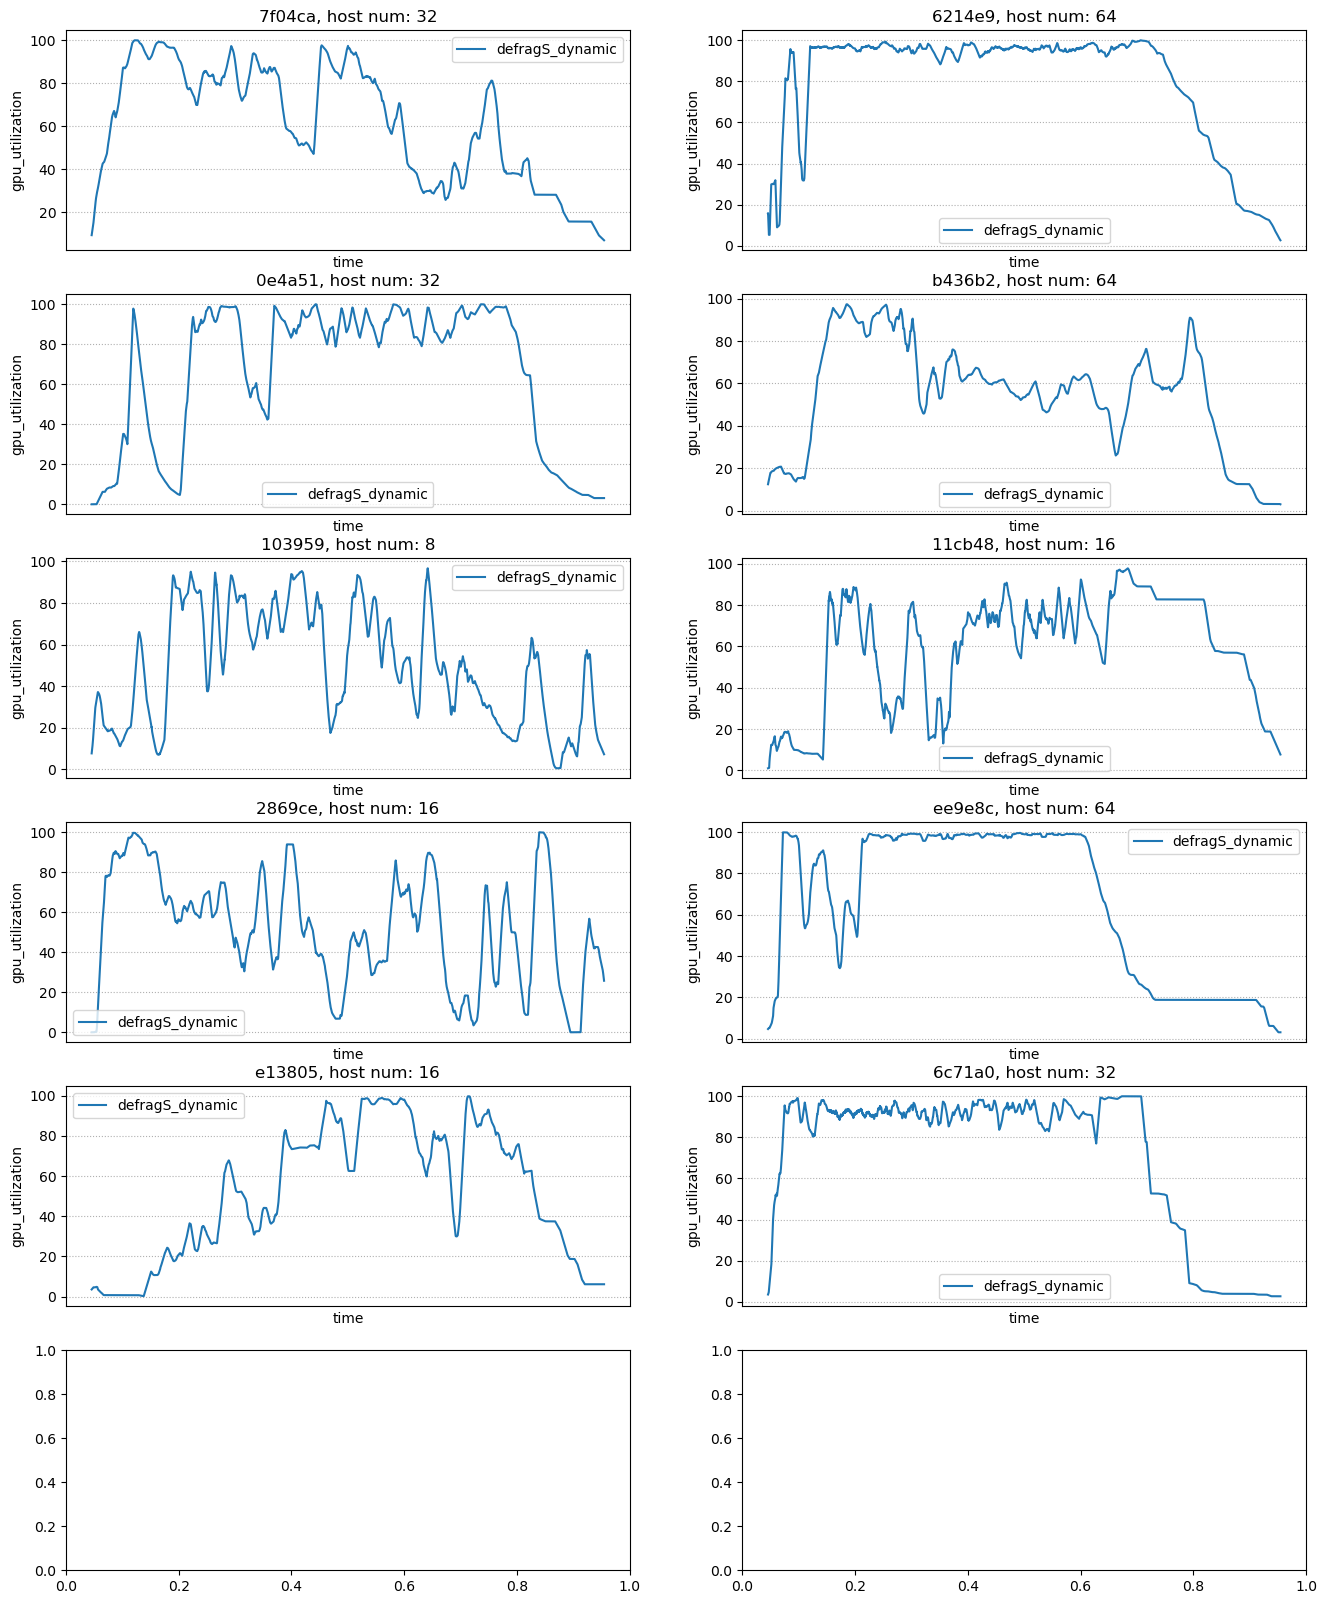

In [5]:
# 在每个VC中话不同调度算法的fragmentation_ratio或gpu_utilization曲线

data_type = 'gpu_utilization'#
vc_dict = pd.read_pickle("/data/nihaifeng/code/HeliosArtifact/simulator/data/Philly/vc_dict_homo.pkl")
log_dir = '../log/noDuration_4/Philly_mutation'
schedulers = ['defragS_dynamic']
window_size = 60*24
vc_ls = os.listdir(log_dir + f'/Philly_{schedulers[0]}')
vc_ls.remove('all')
vc_ls.remove('logfile')
vc_ls.remove('jct_avg.csv')
vc_ls.remove('que_avg.csv')

fig, axes = plt.subplots(6, 2, figsize=(16,20))
axes = axes.flatten() 
for idx, vc in enumerate(vc_ls):
	ax = axes[idx]
	for scheduler in schedulers:
		df = pd.read_csv(log_dir + f'/Philly_{scheduler}/{vc}/{scheduler}_{vc}_seq.csv')
		y = df[data_type]*100
		ax.plot(df['time'], y.rolling(window=window_size).mean(), label=scheduler)
	ax.set_ylabel(data_type)
	ax.set_xlabel('time')
	ax.set_title(f'{vc}, host num: {vc_dict[vc]}')
	ax.set_xticks([])
	ax.grid(linestyle=':')
	ax.legend(loc='best')
plt.show()
	

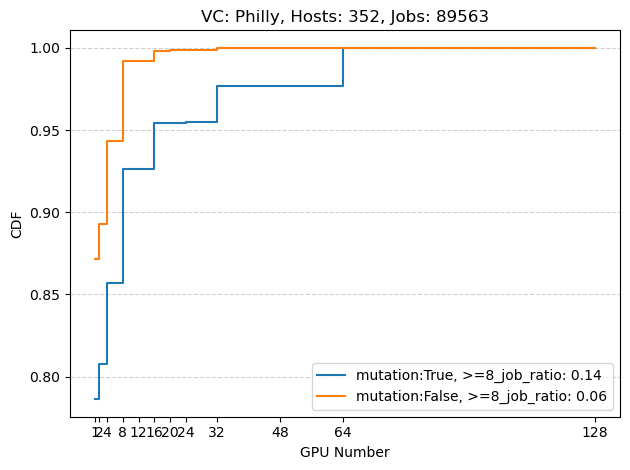

In [7]:
###### jog req GPUs CDF 
trace_dir = '../data/Philly'
vc_dict = pd.read_pickle(trace_dir+'/vc_dict_homo.pkl')
trace_range = ('2017-10-01 00:00:00', '2017-11-30 23:59:00')

for muation in [True, False]:
	trace_df, _ = utils.trace_philly_process(trace_dir, trace_range, vc_dict, muation)
	gpu_num_type = trace_df['gpu_num'].unique()
	gpu_num_type = sorted(gpu_num_type)
	y = [len(trace_df[trace_df['gpu_num'] == x]) for x in gpu_num_type]
	# 计算 CDF
	y_cumsum = np.cumsum(y)  # 累加频率
	y_cdf = y_cumsum / sum(y)  # 归一化
	# 绘制 CDF 图
	plt.step(gpu_num_type, y_cdf, where='post', label=f'mutation:{muation}, >=8_job_ratio: {sum([y[i] for i in range(len(gpu_num_type)) if gpu_num_type[i] >= 8])/trace_df.shape[0]:.2f}')

plt.xlabel('GPU Number')
plt.ylabel('CDF')
plt.title(f"VC: Philly, Hosts: {sum(vc_dict.values())}, Jobs: {trace_df.shape[0]}")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(gpu_num_type)  # 设置x轴刻度为GPU数量
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 画每个VC的Job req GPUs 的统计直方图
trace_dir = '../data/Philly'
vc_dict = pd.read_pickle(trace_dir+'/vc_dict_homo.pkl')

trace_range = ('2017-10-01 00:00:00', '2017-11-30 23:59:00')
trace_df, start_ts = utils.trace_philly_process(trace_dir, trace_range, vc_dict, need_mutation=True)
for vc_name, host_num in vc_dict.items():
	vc_df = trace_df[trace_df['vc'] == vc_name]
	gpu_num_type = vc_df['gpu_num'].unique()
	gpu_num_type = sorted(gpu_num_type)
	y = [len(vc_df[vc_df['gpu_num'] == x]) for x in gpu_num_type]
	
	plt.bar(gpu_num_type, y, color='skyblue', edgecolor='black', alpha=0.7)
	plt.xlabel('GPU Number')
	plt.ylabel('Job number')
	plt.title(f"VC:{vc_name}, Hosts:{host_num}, Jobs:{vc_df.shape[0]}, >=8_job_ratio:{sum([y[i] for i in range(len(gpu_num_type)) if gpu_num_type[i] >= 8])/vc_df.shape[0]:.2f}")
	plt.grid(axis='y', linestyle='--', alpha=0.6)
	plt.xticks(gpu_num_type)  # 设置x轴刻度为GPU数量
	plt.tight_layout()
	plt.show()

# total log
gpu_num_type = trace_df['gpu_num'].unique()
gpu_num_type = sorted(gpu_num_type)
y = [len(trace_df[trace_df['gpu_num'] == x]) for x in gpu_num_type]

plt.bar(gpu_num_type, y, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('GPU Number')
plt.ylabel('Job number')
plt.title(f"VC:Philly, Hosts:{sum(vc_dict.values())}, Jobs:{trace_df.shape[0]}, >=8_job_ratio:{sum([y[i] for i in range(len(gpu_num_type)) if gpu_num_type[i] >= 8])/trace_df.shape[0]:.2f}")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(gpu_num_type)  # 设置x轴刻度为GPU数量
plt.tight_layout()
plt.show()